# CSV to DXF converter

This script gets a file produced by the ski scanner, which is a CSV type containing information on displacement and width, and transforms it into a dxf file which is the input for the laser cutting machine used at Pomoca.

## CSV file read


[note] For now the file is meant for raw noisy data

Import libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from itertools import groupby
import math 
import scipy.interpolate

Import inputs: insettino geometric data, ski nominal length and csv file from sensors

In [12]:
# Insettino geometric data
r = 10 #cm Arms
dx = 2.276 #cm
dy = 1.0 #cm
pins_offset = 0.9 # cm (distance between 2 pins)/2
d = 8 #cm distance between two rotary encoders
offsetW1 = 9 #cm
offsetW2_end = 8 #cm

ski_nominal_length = 176 #cm

# Reading raw data (directory\filename.txt)
df = pd.read_csv(r'Prova00.txt', sep = ",")

r,dx,dy
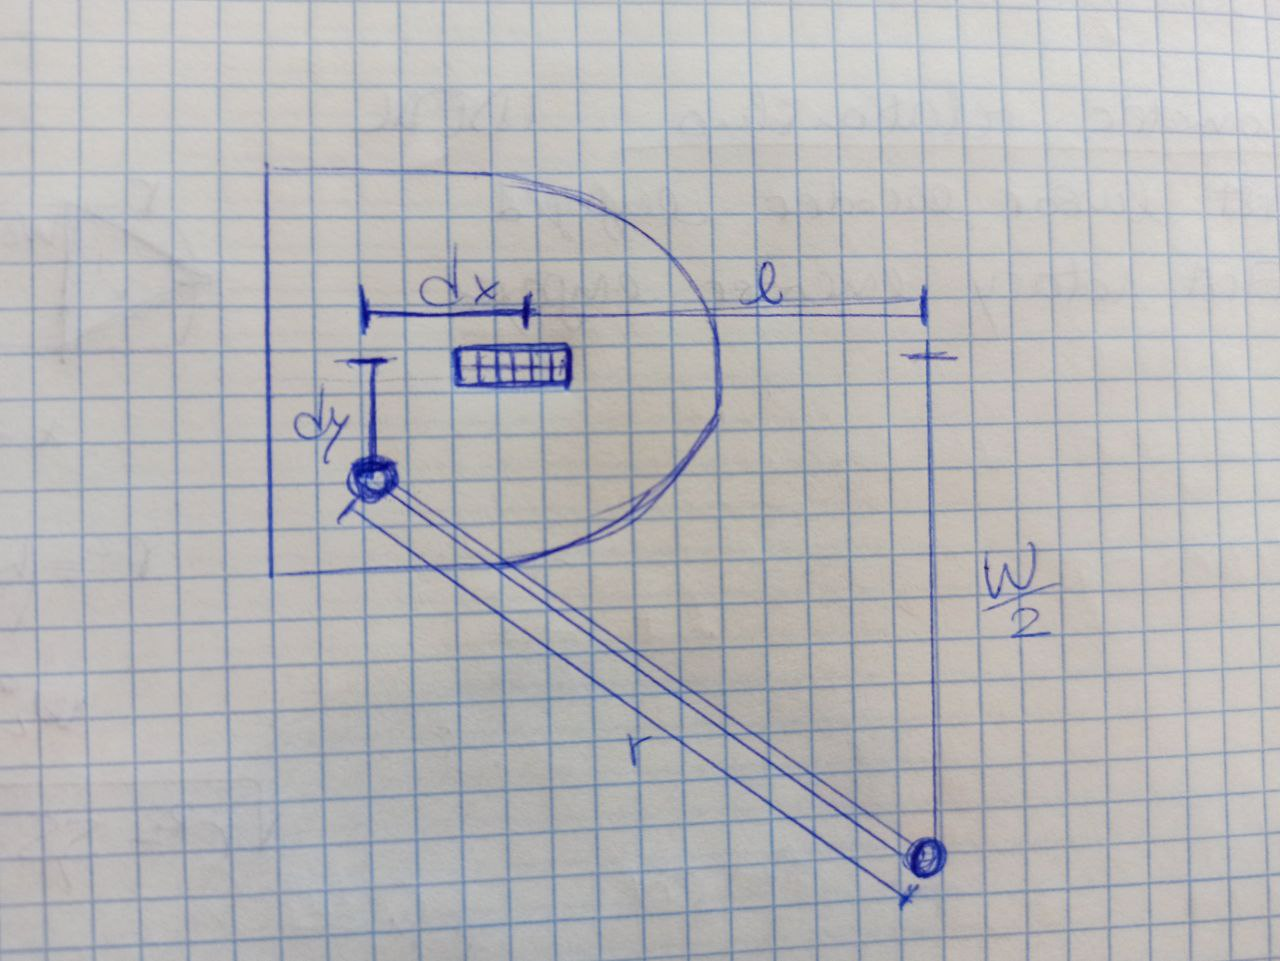

Adjust data from sensors: half width, remove consecutive repeated tuples, drop NaN values

In [13]:
df['W1'] = df['W1']/2 # Half width to plot profile
df['W2'] = df['W2']/2 # Half width to plot profile
df['L2'] = -df['L2'] # One encoder rotates in the opposite way so it detects negative length

# drop NaN column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Remove consecutive repeating tuples (fixed by latest version of arduino code)
cols = ["W1","L1","W2","L2"]
df = df[cols].loc[(df[cols].shift() != df[cols]).any(axis=1)]

# Remove offset in length (fixed by latest version of arduino code)
df['L1'] = df['L1'] - df['L1'].min()
df['L2'] = df['L2'] - df['L2'].min()

# Drop rows with all NaN values
df = df.dropna(axis=0, how='all')

df

,W1,L1,W2,L2
0,0.895,0.59,0.900,0.00
1,0.895,0.59,0.900,0.07
2,0.895,0.59,0.900,0.09
3,0.895,0.59,0.900,0.11
28,0.895,0.67,0.900,0.11
...,...,...,...,...
2797,0.810,187.12,1.225,178.23
2799,0.810,188.41,1.225,178.23
2800,0.810,188.80,1.225,178.24
2803,0.810,189.19,1.225,178.24


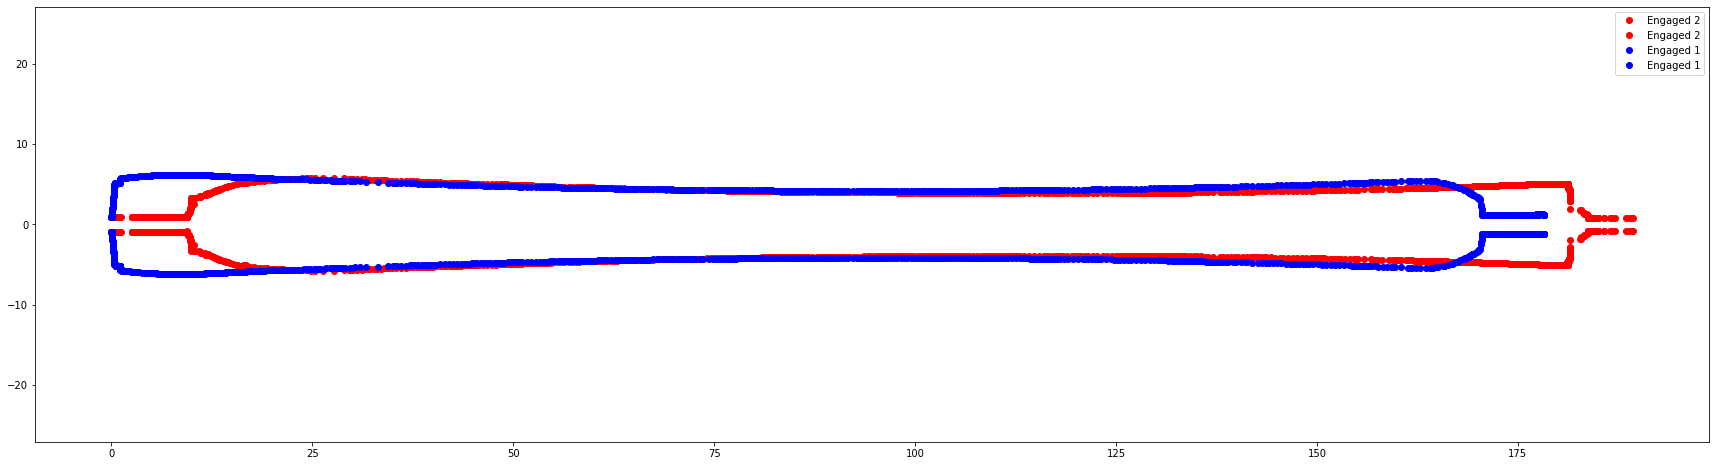

In [14]:
# Plot two sides of the ski

plt.figure(figsize=(30, 8))

plt.plot(df['L1'], df['W1'], 'ro')
plt.plot(df['L1'], -df['W1'], 'ro')

plt.plot(df['L2'], df['W2'], 'bo')
plt.plot(df['L2'], -df['W2'], 'bo')

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

Definition of functions needed to align the measures of lengths and widths

In [16]:
def offset_forward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l + offset
    return l_transformed
def offset_backward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l - offset
    return l_transformed

Identification of engagement of the first couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

In [17]:
# Detect when rotary encoder 2 is engaged (L2 start): Detect changes in L2 data 
changes = df['L2'].pct_change(periods=230)
# Extra condition: geometrically it is engaged around the max width of the ski
start_L2 = df['L2'][(changes>0.9)& (df['W2'] > df['W2'].max()*0.89)].index.values[0] # to be fixed
start_L2

376

Rephasing of W2 and L2 data

In [19]:
# Keep only W2-L2 data after the engagement
df[['L2','W2']] = df[['L2','W2']].loc[start_L2:]
# Reset offset of Length2 that might have been accumulated before the engagement
df['L2'] = df['L2'] - df['L2'].loc[start_L2]
# Add geometrical offset
df['L2'] = offset_forward(df['L2'],df['W2'])
# Visualise the very first starting data
df[['L2','W2']].dropna(axis=0, how='all')

,L2,W2
376,6.634017,5.540
377,6.575446,5.645
378,6.517311,5.700
379,6.591304,5.715
380,6.640597,5.725
...,...,...
2797,185.978920,1.225
2799,185.978920,1.225
2800,185.988920,1.225
2803,185.988920,1.225


Identification of engagement of the second couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

In [20]:
# Detect when linear encoder 1 is engaged (W1 starts changing)
# In theory when W1 data start changing but geometrically it is engaged when L1 is 9.5 cm far and L2 is 9.5 + 8 cm far
changes2 = df.pct_change(periods=100)
# Extra coditions: W1>3.2, L1>offset for W1, L1> 2*offset for W1
start_L1 = df['L1'][(df['W1'] > 3.2) & (changes2['W1']>0.8)  & (df['L1'] > offsetW1) & (df['L2'] > offsetW1+offsetW1)].index.values[0]
start_L1

801

In [21]:
# Keep only W1-L1 data after the engagement
df[['L1','W1']] = df[['L1','W1']].loc[start_L1:] 
# Subtract geometrical offset
df['L1'] = offset_backward(df['L1'],df['W1'])
# Reset offset of Length1 that might have been accumulated before the engagement
df['L1'] = df['L1'] - df['L1'].loc[start_L1]
# Visualise the very first starting data
df[['L1','W1']].dropna(axis=0, how='all')

,L1,W1
801,0.000000,3.215
802,0.004992,3.280
803,-0.021984,3.250
804,-0.036766,3.185
805,-0.054335,3.105
...,...,...
2797,176.923409,0.810
2799,178.213409,0.810
2800,178.603409,0.810
2803,178.993409,0.810


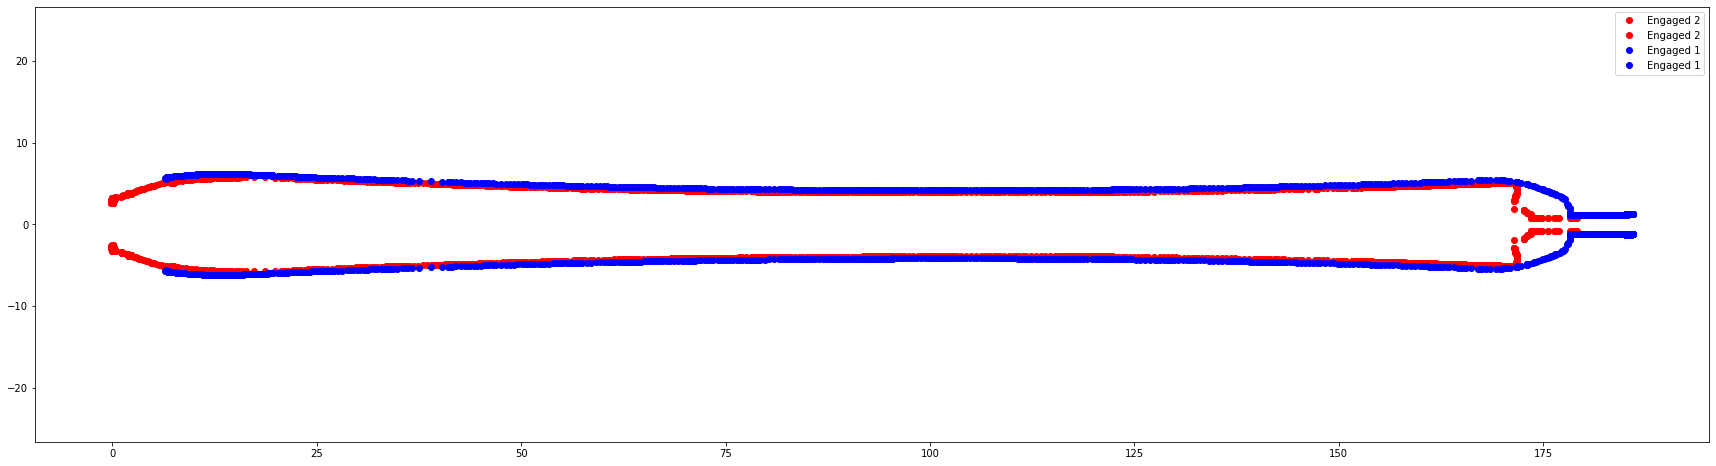

In [22]:
# Plot two sides of the ski

plt.figure(figsize=(30, 8))

plt.plot(df['L1'], df['W1'], 'ro')
plt.plot(df['L1'], -df['W1'], 'ro')

plt.plot(df['L2'], df['W2'], 'bo')
plt.plot(df['L2'], -df['W2'], 'bo')

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

Identification of disengagement of the first couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

In [23]:
# Detect when linear encoder 2 is disengaged (W2 ends)
# Conditions: around the nominal length of the ski, decreasing trend of the data, small changes in W2 are excluded
end_L2 = df[(df['L2'] > ski_nominal_length-offsetW2_end) & (df['W2'].shift(1) > df['W2']) & (df['W2'].shift(1) - df['W2']> 0.05)].index.values[-1]
df['L2'] = df['L2'].loc[:end_L2]

# Detect when linear encoder 1 is disengaged (W1 ends)
# Conditions: around the nominal length of the ski, W1 not changing abruptly, W1 bigger than minimal distance between pins

end_L1 = df[(df['L1'] > ski_nominal_length-offsetW2_end) & (df['W1'] - df['W1'].shift(-4) < 0.0001) & (df['W1'] > pins_offset)].index.values[-1] 
df['L1'] = df['L1'].loc[:end_L1]

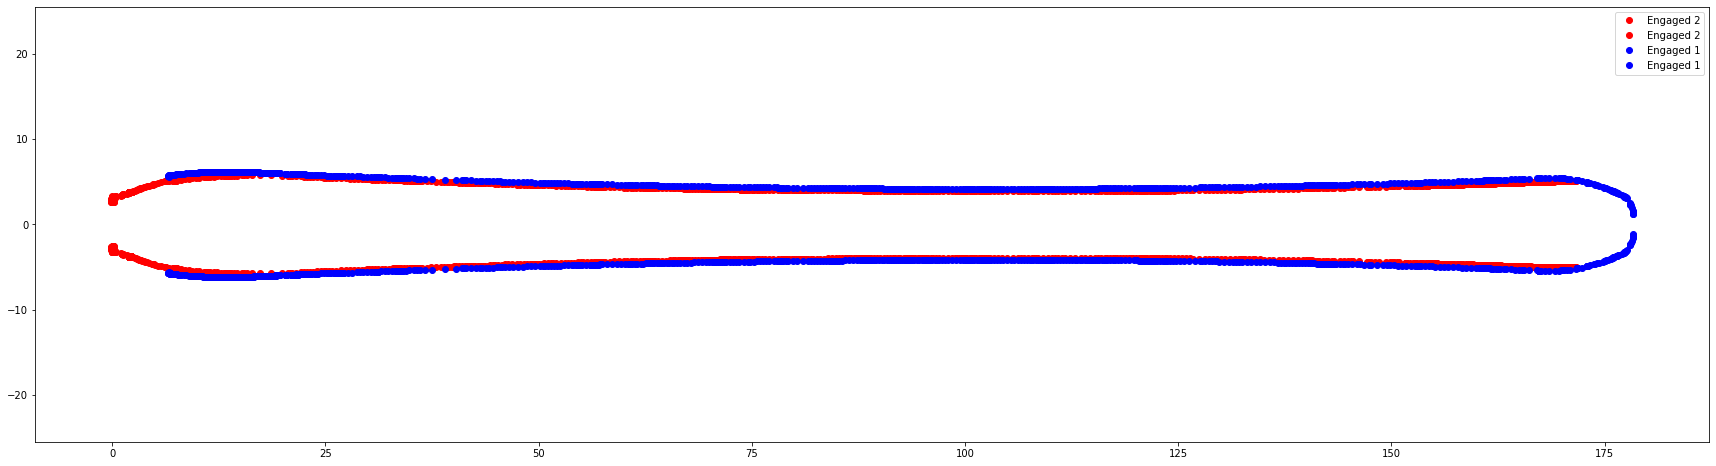

In [24]:
# Plot two sides of the ski

plt.figure(figsize=(30, 8))

plt.plot(df['L1'], df['W1'], 'ro')
plt.plot(df['L1'], -df['W1'], 'ro')

plt.plot(df['L2'], df['W2'], 'bo')
plt.plot(df['L2'], -df['W2'], 'bo')

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

In [25]:
# Drop rows with all NaN values
df = df.dropna(axis=0, how='all')

# Merging data from 2 couples of sensors data in one single ski profile

In this section an approach of mean computation of the nearest points is implemented:
For each point coming from one couple of sensors an interval of the closest points from the other couple of sensors is selected, the euclidean distance from each point of the interval is computed and the nearest is select for the mean computation. 

In [26]:
# Start iterating the secondly engaged sensors: when I get closed to firstly engaged sensor I start mediating
start_L2 = df['L2'].min() #After all sensors are engaged the merging should begin (Start_L2 represents the starting moment)
delta = 5 #Maximum distance from the current point included in the interval of the closest points

ski_profile = pd.DataFrame(columns=['W','L'])

for i in range(1,len(df['L1'])): #iterate the secondly-engaged sensors data
    
    if (df['L1'].iloc[i] < start_L2): #at the beginning no merging is needed: save all data points in ski profile
        df_temp = pd.DataFrame(df[['W1','L1']].iloc[i]).transpose()
        df_temp = df_temp.rename(columns={"W1": "W", "L1": "L"})
        ski_profile = ski_profile.append(df_temp)
        
    elif (df['L1'].iloc[i] >= start_L2): # When both sets of data are available save their mean in ski profile
        
        #find closest value of firstly engaged sensors
        close_interval = df[['W2','L2']][abs(df['L1'].iloc[i]-df['L2']) < delta] 
        min_dist = 1000 #initialise the minimum distance to a very high value
        closest_value = [] #initialise a variable to save the closest point among the points in the interval
        for j in range(1,len(close_interval)): #iterate over the selected interval
            a = df[['W1','L1']].iloc[i].to_numpy()
            b = close_interval.iloc[j].to_numpy()
            dist = np.linalg.norm(a-b)
            if (dist < min_dist):
                min_dist = dist
                closest_value = pd.DataFrame(close_interval.iloc[j]).transpose()
                closest_value = closest_value.rename(columns={"W2": "W", "L2": "L"})
                curr_point = pd.DataFrame(df[['W1','L1']].iloc[i]).transpose()
        curr_point = curr_point.rename(columns={"W1": "W", "L1": "L"})
        mean_point = pd.DataFrame(curr_point.append(closest_value).mean()).transpose() #compute the mean between two the closest value and the current value
        ski_profile = ski_profile.append(mean_point) #save mean in ski profile


In [27]:
# At the end no merging is needed: save all data points in ski profile
# Add tail to ski profile
tail = df[['W2','L2']][df['L2']> df['L1'].dropna(axis=0, how='all').iloc[-1]]
tail = tail.rename(columns={"W2": "W", "L2": "L"})
ski_profile = ski_profile.append(tail)

In [28]:
ski_profile

,W,L
801,3.215,0.000000
802,3.280,0.004992
803,3.250,-0.021984
804,3.185,-0.036766
805,3.105,-0.054335
...,...,...
2349,1.525,178.296402
2350,1.420,178.316335
2351,1.320,178.323741
2352,1.245,178.327980


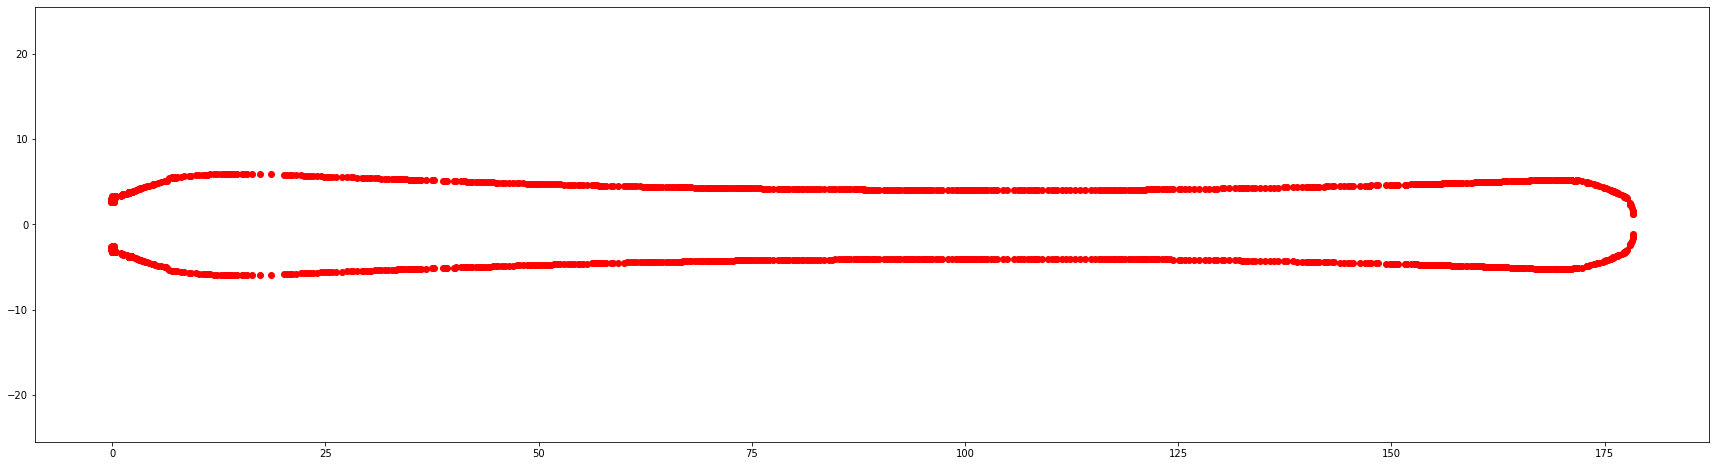

In [29]:
# Plot two sides of the ski

plt.figure(figsize=(30, 8))

plt.plot(ski_profile['L'], ski_profile['W'], 'ro')
plt.plot(ski_profile['L'], -ski_profile['W'], 'ro')

plt.axis('equal')
plt.show()

In [31]:
# For Isabella
# ski_profile.to_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\sensorsdata.csv', index = False)

# For Raph (Mac)
ski_profile.to_csv(r'sensorsdata.csv', index = False)

# Spline generation and saving in dxf file

Division of data in sections (from 0 to 14% of length for tip section, from 94% of length to end for tail section) and spline generation

Define function to find the closest point of a dataframe array to a point

In [32]:
def closest_point(point, df):
    delta = 10
    close_interval = df[abs(df-point) < delta] 
    min_dist = 1000 #initialise the minimum distance to a very high value
    closest_value = [] #initialise a variable to save the closest point among the points in the interval
    for j in range(1,len(close_interval)): #iterate over the selected interval
        
        a = point
        b = close_interval.iloc[j]
        
        dist = np.linalg.norm(a-b)
        if (dist < min_dist):
            min_dist = dist
            closest_value = b
    
    return closest_value

Selection of section extremes

In [33]:
ski_profile = ski_profile.sort_values('L',ascending=True)
max_length = ski_profile['L'].max()

start_section1 = closest_point(0*max_length,ski_profile['L']) 
end_section1 = closest_point(0.14*max_length,ski_profile['L']) 

start_section2 = end_section1
end_section2 = closest_point(0.95*max_length,ski_profile['L'])

start_section3 = end_section2
end_section3 = max_length

Generation of splines and plot

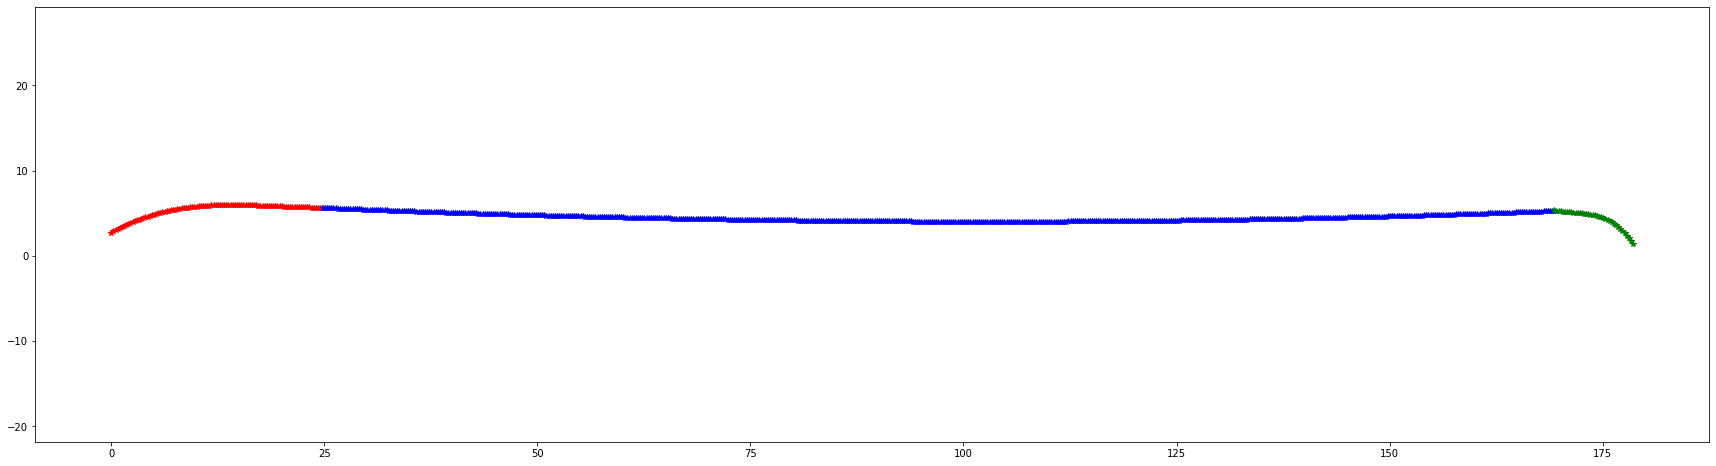

In [34]:
plt.figure(figsize=(30, 8))
dx = 0.25

section1 = ski_profile[['L','W']][ (ski_profile['L']>=start_section1) & (ski_profile['L']<=end_section1)]
myspline1 = scipy.interpolate.UnivariateSpline(section1['L'].to_numpy(), section1['W'].to_numpy())
x1 = np.arange(start_section1, end_section1, dx)
y_myspline1 = myspline1(x1)
plt.plot(x1, y_myspline1, 'r*')

section2 = ski_profile[['L','W']][ (ski_profile['L']>=start_section2) & (ski_profile['L']<=end_section2)]
myspline2 = scipy.interpolate.UnivariateSpline(section2['L'].to_numpy(), section2['W'].to_numpy())
x2 = np.arange(start_section2, end_section2, dx)
y_myspline2 = myspline2(x2)
plt.plot(x2, y_myspline2, 'b*')

section3 = ski_profile[['L','W']][ (ski_profile['L']>=start_section3) & (ski_profile['L']<=end_section3)]
myspline3 = scipy.interpolate.UnivariateSpline(section3['L'].to_numpy(), section3['W'].to_numpy())
x3 = np.arange(start_section3, end_section3+dx, dx)
y_myspline3 = myspline3(x3)
plt.plot(x3, y_myspline3, 'g*')

plt.axis('equal')
plt.show()

Add splines to dxf modelspace

In [36]:
# Create a new DXF document.
doc = dxf.new(dxfversion='R2010')

# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).  
msp = doc.modelspace()

section1 = np.concatenate([x1[:-1,np.newaxis],y_myspline1[:-1,np.newaxis]],axis = 1)
section1 = np.vstack([section1, [start_section2, myspline2(start_section2)]])

section2 = np.concatenate([x2[:,np.newaxis],y_myspline2[:,np.newaxis]],axis = 1)
section2 = np.vstack([section2, [start_section3, myspline3(start_section3)]])

section3 = np.concatenate([x3[:,np.newaxis],y_myspline3[:,np.newaxis]],axis = 1)
section4 = np.concatenate([x1[:,np.newaxis],-y_myspline1[:,np.newaxis]],axis = 1)
section5 = np.concatenate([x2[:,np.newaxis],-y_myspline2[:,np.newaxis]],axis = 1)
section6 = np.concatenate([x3[:,np.newaxis],-y_myspline3[:,np.newaxis]],axis = 1)

# Add entities (spline) to a layout by factory methods: layout.add_...() 
msp.add_cad_spline_control_frame(fit_points = section1, tangents = [(0,1,0),(0,1,0)])

msp.add_spline(section1)

msp.add_spline(section2)
msp.add_spline(section3)
msp.add_spline(section4)
msp.add_spline(section5)
msp.add_spline(section6)
msp.add_line((start_section1,myspline1(start_section1)),(start_section1,-myspline1(start_section1)))
msp.add_line((end_section3,myspline3(end_section3)),(end_section3,-myspline3(end_section3)))

# Save DXF document.
doc.saveas('test.dxf')

Visualisation of dxf file

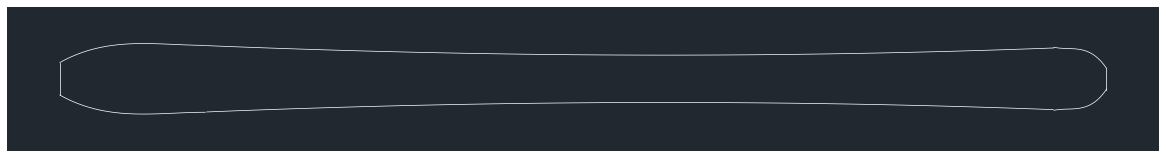

In [174]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile('test.dxf')
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)